# CS224N Assignment 1: Exploring Word Vectors (25 Points)
### <font color='blue'> Due 4:30pm, Tue January 14th 2025</font>

Welcome to CS224N! 

Before you start, make sure you **read the README.md** in the same directory as this notebook for important setup information. You need to install some Python libraries before you can successfully do this assignment. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning :)

If you aren't super familiar with Python, Numpy, or Matplotlib, we recommend you check out the review session on Friday. The session will be recorded and the material will be made available on our [website](http://web.stanford.edu/class/cs224n/index.html#schedule). The CS231N Python/Numpy [tutorial](https://cs231n.github.io/python-numpy-tutorial/) is also a great resource.


**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [3]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 8

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.md file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from datasets import load_dataset
imdb_dataset = load_dataset("stanfordnlp/imdb", name="plain_text")

import re
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NUM_SAMPLES = 150

np.random.seed(0)
random.seed(0)
# ----------------

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points) 基于计数的共现矩阵并降维得到向量（Count-based 方法）

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://web.stanford.edu/~jurafsky/slp3/6.pdf) or [here](https://web.archive.org/web/20190530091127/https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

In NLP, we commonly use `<START>` and `<END>` tokens to mark the beginning and end of sentences, paragraphs, or documents. These tokens are included in co-occurrence counts, encapsulating each document, for example: "`<START>` All that glitters is not gold `<END>`".

The matrix rows (or columns) provide word vectors based on word-word co-occurrence, but they can be large. To reduce dimensionality, we employ Singular Value Decomposition (SVD), akin to PCA, selecting the top $k$ principal components. The SVD process decomposes the co-occurrence matrix $A$ into singular values in the diagonal $S$ matrix and new, shorter word vectors in $U_k$.

This dimensionality reduction maintains semantic relationships; for instance, *doctor* and *hospital* will be closer than *doctor* and *dog*.

For those unfamiliar with eigenvalues and SVD, a beginner-friendly introduction to SVD is available [here](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). Additional resources for in-depth understanding include lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168, providing high-level treatment of these algorithms. For practical implementation, utilizing pre-programmed functions from Python packages like numpy, scipy, or sklearn is recommended. While applying full SVD to large corpora can be memory-intensive, scalable techniques such as Truncated SVD exist for extracting the top $k$ vector components efficiently.

### Plotting Co-Occurrence Word Embeddings 数据读取 & 预处理（read_corpus）

把 IMDb 文本读入，做简单的分词/小写/去标点，给每条评论加上 <START> / <END> 标记，得到一个 corpus（list of list of tokens）。这是后续构造共现矩阵的输入。

Here, we will be using the Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. We provide a `read_corpus` function below that pulls out the text of a movie review from the dataset. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [ ]:
def read_corpus():
    """ Read files from the Large Movie Review Dataset.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = imdb_dataset["train"]["text"][:NUM_SAMPLES]
    return [[START_TOKEN] + [re.sub(r'[^\w]', '', w.lower()) for w in f.split(" ")] + [END_TOKEN] for f in files]
# 返回嵌套列表，每个子列表包含一个文件的所有单词；
# 将文本按空格分割成单词列表，转小写，移除非字母数字字符；
# 前后添加特殊标记；

Let's have a look what these documents are like….

In [ ]:
imdb_corpus = read_corpus()
pprint.pprint(imdb_corpus[:3], compact=True, width=100)
print("corpus size: ", len(imdb_corpus[0]))
# 总共是 150 条电影评论，输出了前 3 条评论的内容，每条评论都被处理成了一个单词列表，打印的是第一条评论中的单词数量（包括特殊标记）；

[['<START>', 'i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because',
  'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first',
  'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized',
  'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore',
  'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to',
  'see', 'this', 'for', 'myselfbr', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young',
  'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything',
  'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her',
  'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average',
  'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam',
  'war', 'and', 'race', 'issu

### Question 1.1: Implement `distinct_words` [code] (2 points) 去除重复token并排序

在后面的共现矩阵构造里，我们要建立一个矩阵 
𝑀，M∈$R^{∣V∣×∣V∣}$，其中 |V| 是词汇表大小（vocabulary size）。如果不去重，你可能会重复计入同一个词，导致矩阵的行列数大于实际词表大小，或者映射字典 word2ind 出现冲突。

Write a method to work out the distinct words (word types) that occur in the corpus.

You can use `for` loops to process the input `corpus` (a list of list of strings), but try using Python list comprehensions (which are generally faster). In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [ ]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    corpus_words = sorted(set([word for document in corpus for word in document]))
    n_corpus_words = len(corpus_words)
    return corpus_words, n_corpus_words
# 找出语料库中出现的不同单词并排序

In [13]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points) 构造共现矩阵

遍历 corpus，对每个“中心词”在一个窗口内统计周围词出现次数，得到 M（词 × 词 的共现计数矩阵），并返回 word2ind（词→索引）。

① 窗口大小会显著影响共现（短窗口更捕捉语法、长窗口更捕捉主题）；

② 数据量太小（你只用 NUM_SAMPLES=150）会导致矩阵非常稀疏，信息少，降维后效果差（这就是你观察到左图点“挤在一起”的原因）。

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [ ]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    # 获取所有不重复的单词及其数量
    words, n_words = distinct_words(corpus)
    
    # 创建单词到索引的映射字典
    word2ind = dict(zip(words, range(n_words)))
    
    # 初始化共现矩阵为0矩阵
    M = np.zeros((n_words, n_words))
    
    # 遍历每个文档
    for document in corpus:
        # 遍历文档中的每个单词位置
        for i in range(len(document)):
            # 获取中心词的索引
            word_idx = word2ind[document[i]]
            
            # 计算窗口的左右边界
            window_start = max(0, i - window_size)
            window_end = min(len(document), i + window_size + 1)
            
            # 遍历窗口内的单词(不包括中心词本身)
            for j in range(window_start, window_end):
                if i != j:  # 不统计单词与自己的共现
                    context_idx = word2ind[document[j]]
                    M[word_idx, context_idx] += 1
    
    return M, word2ind
# 输出共现矩阵和映射字典

In [17]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point) 降维

原始共现矩阵/词向量维度太高（不可视）；SVD 可以把数据的主要线性成分压缩到少量维度，便于观察语义结构。

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [22]:
def reduce_to_k_dim(M, k=2):
    
    n_iters = 10   
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # 创建 TruncatedSVD 实例
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    
    # 对共现矩阵进行降维,得到 U*S，同时拟合模型并转换数据。fit_transform 返回的矩阵通常对应于 U * S 的近似（奇异向量左矩阵乘以对应奇异值）
    M_reduced = svd.fit_transform(M)
    
    print("Done.")
    return M_reduced
# 构建一种对矩阵进行降维以生成 k 维嵌入的方法。使用 SVD 提取前 k 个分量并生成一个新的 k 维嵌入矩阵。

In [23]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# (n_words, k)
# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [24]:
def plot_embeddings(M_reduced, word2ind, words):
    # 创建新的图形
    plt.figure()
    
    # 获取要可视化的词的坐标
    x_coords = [M_reduced[word2ind[w], 0] for w in words]
    y_coords = [M_reduced[word2ind[w], 1] for w in words]
    
    # 绘制散点图
    plt.scatter(x_coords, y_coords, marker='o')

    # 为每个点添加文本标签
    for i, word in enumerate(words):
        plt.annotate(word,
                    (x_coords[i], y_coords[i]), # 点的坐标
                    xytext=(5, 2), textcoords='offset points', 
                    fontsize=8)            
    
    # 设置图形属性
    plt.xlabel("Dimension 1")    # x轴标签
    plt.ylabel("Dimension 2")    # y轴标签
    plt.title("Word Embeddings") # 图形标题
    
    # 调整布局以防止标签重叠
    plt.tight_layout()
    
    # 显示图形
    plt.show()
    # 在二维空间中绘制一组二维向量

--------------------------------------------------------------------------------
Outputted Plot:


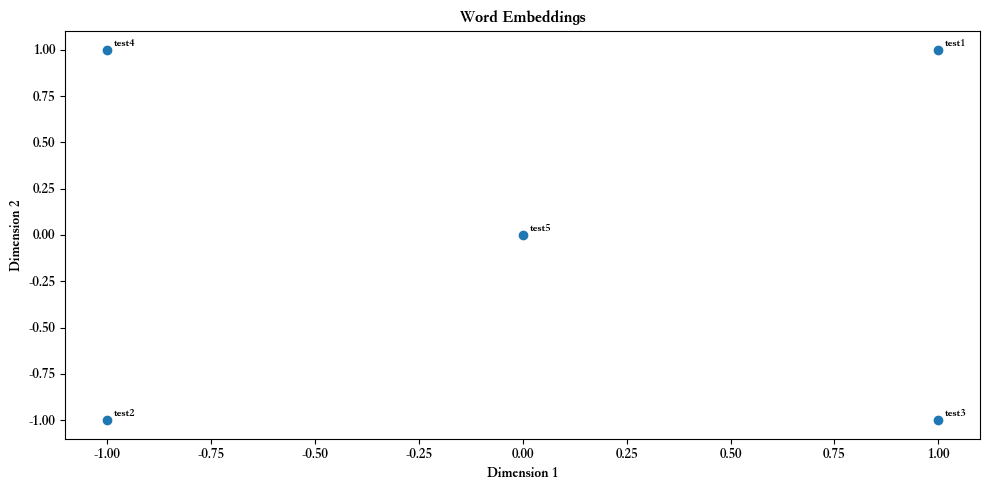

--------------------------------------------------------------------------------


In [25]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the included file question_1.4_test.png 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

虽然图上画的是点，但每个点就是一个向量，点到原点的距离就是向量的长度。

SVD 返回的向量既包含方向信息也包含被奇异值或频率放大的尺度信息，这会影响可视化与相似度判定。

所以常用 L2 归一化 来把焦点放在“方向（语义）”上，便于用余弦相似度比较和绘图展示。

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Large Movie Review corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It can take up to a few minutes to run.

| 小节         | 任务                 | 目标                             |
| ---------- | ------------------ | ------------------------------ |
| **1.1**    | 获取所有不同的词并排序        | 构建词汇表                          |
| **1.2**    | 计算共现矩阵             | 把“词的上下文关系”数值化                  |
| **1.3**    | 用 SVD 降维           | 把高维的统计关系映射到低维空间                |
| **1.4**    | 绘制二维向量             | 可视化语义结构                        |
| **➡️ 1.5** | **运行整体流程 + 加上归一化** | 检查模型是否工作正常，并为之后的 GloVe 部分做对比准备 |


Running Truncated SVD over 5880 words...
Done.


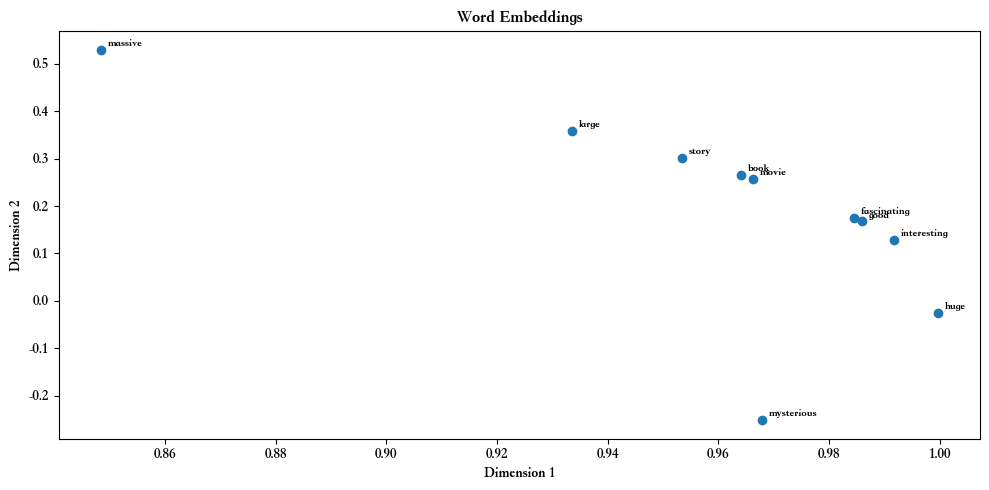

In [54]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
imdb_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(imdb_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
# L2 归一化（unit length），即把每一行向量除以它的长度，使其长度为 1，L2 归一化能让方向保持一致，方便用余弦相似度做比较
words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']
# 绘图的时候只挑了“几个词”出来

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

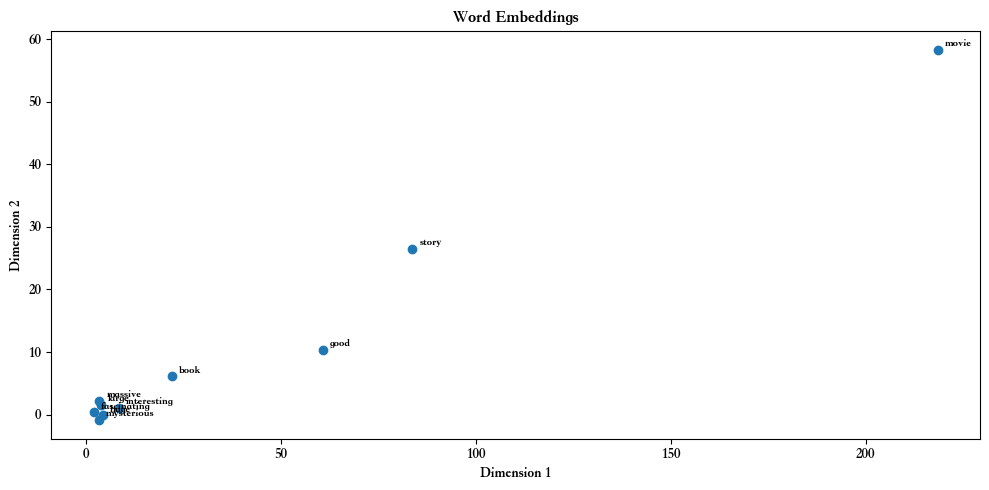

In [ ]:
plot_embeddings(M_reduced_co_occurrence, word2ind_co_occurrence, words)

# 高频词（如 “the”、“movie”）共现次数很多，对应向量长度很大；
# 低频词（如 “mysterious”）长度很小。
# 如果你直接画图，高频词会“挤在一起”或“拉伸空间”。
# 归一化后：所有向量长度统一为 1，比较的只剩“方向”——即语义关系。

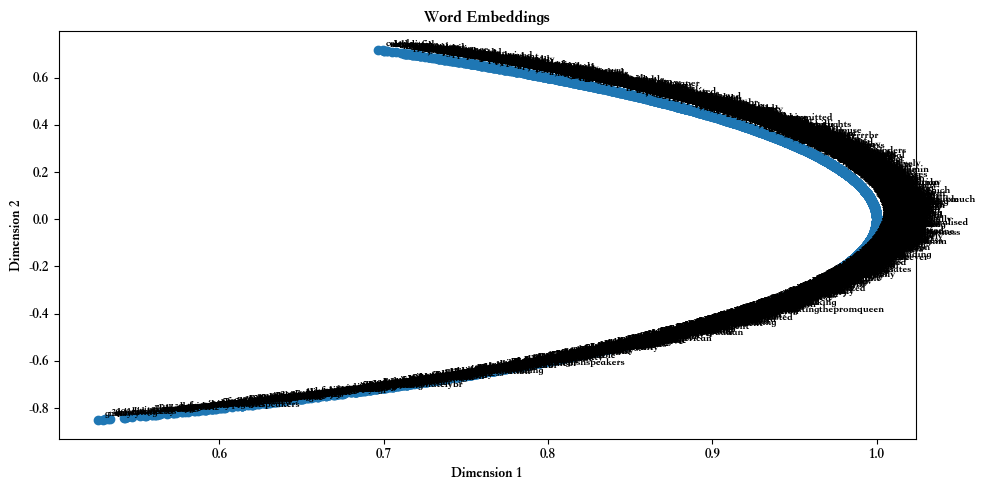

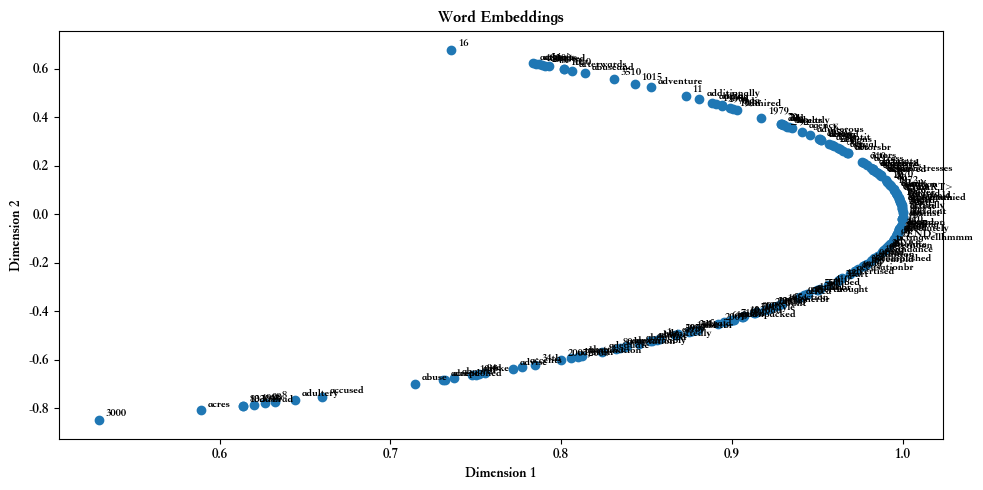

In [ ]:
all_words = list(word2ind_co_occurrence.keys())
plot_embeddings(M_normalized, word2ind_co_occurrence, all_words)

words_to_plot = all_words[:200]  # 只取前200个词
plot_embeddings(M_normalized, word2ind_co_occurrence, words_to_plot)

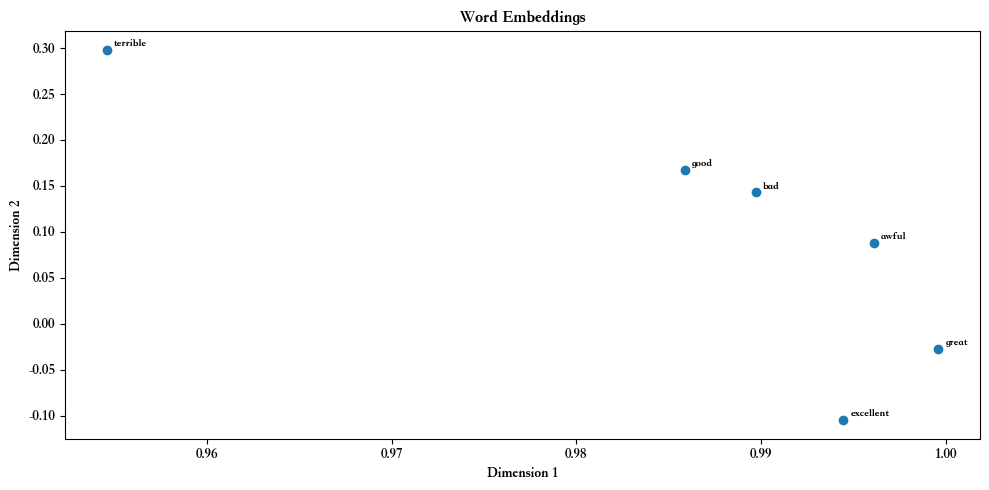

In [ ]:
words = ['good','great','bad','terrible','excellent','awful']
plot_embeddings(M_normalized, word2ind_co_occurrence, words)

**Verify that your figure matches "question_1.5.png" in the assignment zip. If not, use the figure in "question_1.5.png" to answer the next two questions.**

a. Find at least two groups of words that cluster together in 2-dimensional embedding space. Give an explanation for each cluster you observe.

#### <font color="red">Write your answer here.</font>


b. What doesn't cluster together that you might think should have? Describe at least two examples.

#### <font color="red">Write your answer here.</font>

| 对比项  | 基于计数（你前面实现的） | 基于预测（Word2Vec）      | GloVe            |
| ---- | ------------ | ------------------- | ---------------- |
| 核心思想 | 明确数共现次数      | 预测上下文词              | 用 log(共现) 作为监督信号 |
| 计算方式 | 统计矩阵 + SVD   | 神经网络训练              | 矩阵拟合 + 神经网络优化    |
| 数据结构 | 明确共现矩阵       | 直接遍历语料              | 共现矩阵但只训练非零部分     |
| 优点   | 简单可解释        | 精确捕捉上下文             | 结合两者优势           |
| 代表模型 | PPMI, LSA    | Word2Vec, Skip-gram | GloVe            |
| 输出   | 固定词向量        | 固定词向量               | 固定词向量（200维/300维） |


## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [ ]:
# 加载预训练词向量
def load_embedding_model():
    """Load local GloVe vectors (converted to word2vec format)"""
    from gensim.scripts.glove2word2vec import glove2word2vec
    from gensim.models import KeyedVectors
    import os

    # 路径配置
    glove_input_file = "/Users/zhangyuxin/Pycharm_Projects/py_works/cs224n/glove.6B/glove.6B.200d.txt"
    word2vec_output_file = "/Users/zhangyuxin/Pycharm_Projects/py_works/cs224n/glove.6B.200d.word2vec.txt"

    # 如果还没转换过，就转换一次
    if not os.path.exists(word2vec_output_file):
        print("Converting GloVe format to word2vec format...")
        glove2word2vec(glove_input_file, word2vec_output_file)

    # 加载模型
    print("Loading model...")
    wv_from_bin = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    print("✅ Loaded vocab size:", len(wv_from_bin))

    return wv_from_bin

# 运行
wv_from_bin = load_embedding_model()


Converting GloVe format to word2vec format...


/var/folders/7w/cqqy7mgs3zv90jrf16w5fksr0000gn/T/ipykernel_86776/1709120793.py:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


Loading model...
✅ Loaded vocab size: 400000


In [57]:
print(wv_from_bin['king'])
print(wv_from_bin.most_similar('movie'))
wv_from_bin['king'].shape

[-0.49346   -0.14768    0.32166    0.056899   0.052572   0.20192
 -0.13506   -0.030793   0.15614   -0.23004   -0.66376   -0.27316
  0.10391    0.57334   -0.032355  -0.32766   -0.2716     0.32919
  0.41305   -0.18085    1.5167     2.1649    -0.10278    0.098019
 -0.018946   0.027292  -0.7948     0.36631   -0.33151    0.2884
  0.10436   -0.19166    0.27326   -0.17519   -0.14986   -0.072333
 -0.54371   -0.29728    0.081491  -0.42673   -0.36406   -0.52035
  0.18455    0.44121   -0.32196    0.39172    0.11952    0.36979
  0.29229   -0.42954    0.46653   -0.067243   0.31216   -0.17216
  0.48874    0.2803    -0.17577   -0.35101    0.020792   0.15974
  0.21927   -0.32499    0.086022   0.38927   -0.65638   -0.67401
 -0.41896    1.2709     0.20857    0.28315    0.58238   -0.14944
  0.3989     0.52681    0.35714   -0.39101   -0.55372   -0.56642
 -0.15762   -0.48004    0.40448    0.057518  -1.0157     0.21755
  0.073296   0.15237   -0.38362   -0.75308   -0.0060254 -0.26232
 -0.54102   -0.34347    

(200,)

#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

把 GloVe 降维并与共现结果比较

Running Truncated SVD over 10 words...
Done.


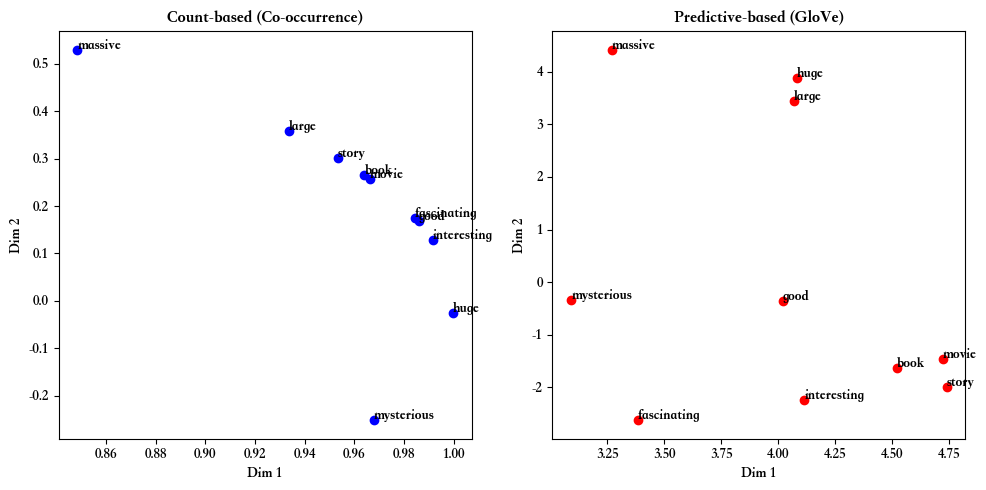

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ========== 1️⃣ 取出 GloVe 向量 ==========
# 我们选取与共现矩阵相同的词
common_words = ['movie', 'book', 'mysterious', 'story', 
                'fascinating', 'good', 'interesting', 
                'large', 'massive', 'huge']

# 从 GloVe 模型里取出这些词的向量
glove_vectors = []
found_words = []
for w in common_words:
    if w in wv_from_bin:
        glove_vectors.append(wv_from_bin[w])
        found_words.append(w)
    else:
        print(f"⚠️ {w} 不在 GloVe 模型中")

M_glove = np.stack(glove_vectors) # (n个词, 200)

# ========== 2️⃣ GloVe 降维到二维 ==========
M_glove_reduced = reduce_to_k_dim(M_glove, k=2)

# ========== 3️⃣ 从共现矩阵降维结果中取对应词 ==========
cooc_vectors = []
found_cooc = []
for w in found_words:
    if w in word2ind_co_occurrence:
        idx = word2ind_co_occurrence[w]
        cooc_vectors.append(M_normalized[idx])
        found_cooc.append(w)

M_cooc = np.stack(cooc_vectors) # (n个词, 2)

# ========== 4️⃣ 画两张图对比 ==========
plt.figure(figsize=(10, 5))

# 左边：共现矩阵结果
plt.subplot(1, 2, 1)
plt.scatter(M_cooc[:, 0], M_cooc[:, 1], c='blue')
for i, word in enumerate(found_cooc):
    plt.annotate(word, (M_cooc[i, 0], M_cooc[i, 1]))
plt.title("Count-based (Co-occurrence)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

# 右边：GloVe 结果
plt.subplot(1, 2, 2)
plt.scatter(M_glove_reduced[:, 0], M_glove_reduced[:, 1], c='red')
for i, word in enumerate(found_words):
    plt.annotate(word, (M_glove_reduced[i, 0], M_glove_reduced[i, 1]))
plt.title("Predictive-based (GloVe)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

plt.tight_layout()
plt.show()


| 项目   | 共现矩阵 (Count-based) | GloVe (Predictive-based) |
| ---- | ------------------ | ------------------------ |
| 数据来源 | 直接统计共现次数           | 模型预测上下文概率                |
| 信息类型 | 局部统计               | 全局统计 + 语义优化              |
| 降维方式 | SVD                | 训练得到                     |
| 优点   | 可解释性强、简单           | 表达语义强、效果好                |
| 缺点   | 词稀疏、噪声多            | 模型复杂、难解释                 |
| 图像特征 | 分布紧密、结构模糊          | 聚类明显、语义清晰                |


### Reducing dimensionality of Word Embeddings

对整个词向量矩阵（几千个词）进行统一降维，
得到一个低维空间（比如 2 维或 50 维），用于后续分析或比较。

gensim 的 wv_from_bin 不是 numpy 数组，而是一个 键值字典结构
也就是说：

它的内部不是一个规则的二维矩阵；

你不能直接说 “取前40000行”；

必须自己指定要哪些词、以什么顺序放进矩阵。

Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 40000 GloVe vectors instead.
Run the following cells to:

1. Put 40000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [ ]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(46)
    random.shuffle(words)
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {},M = []
    curInd = 0 # 行索引计数器
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w)) # 从 gensim 模型里取出向量值
            word2ind[w] = curInd
            curInd += 1 # 手动维护 “词 → 行号” 映射
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

```text
GloVe 模型 (wv_from_bin)
        │
        │（按词取出向量）
        ▼
+----------------------------+
| M = [v_movie, v_book, ...] |  ← Python 列表（每个元素是200维）
+----------------------------+
        │
        │（堆叠成真正的矩阵）
        ▼
numpy矩阵 M.shape = (40000, 200)
        │
        │（字典记录行号）
        ▼
word2ind = {'movie': 0, 'book': 1, ...}


In [ ]:
# 归一化-----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 400000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 400000 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']`.

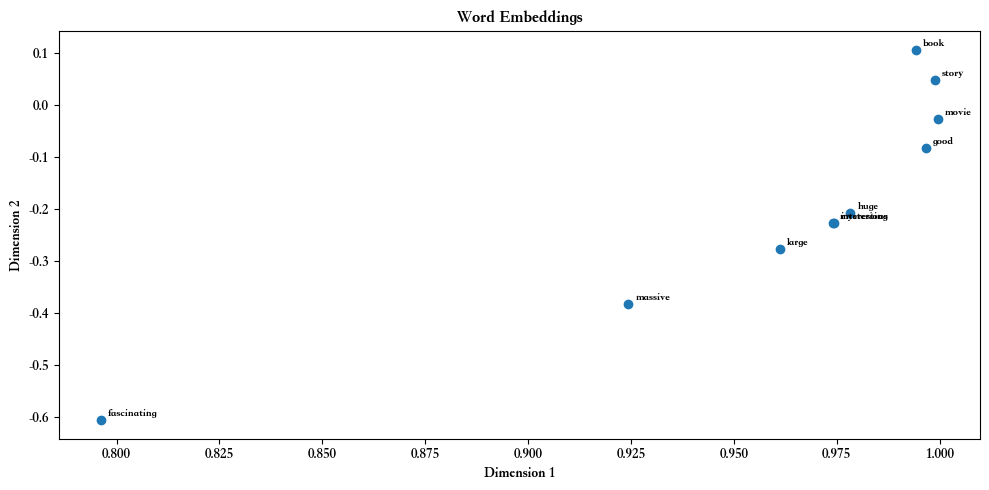

In [39]:
words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']

plot_embeddings(M_reduced_normalized, word2ind, words)

**Verify that your figure matches "question_2.1.png" in the assignment zip. If not, use the figure in "question_2.1.png" (and the figure in "question_1.5.png", if applicable) to answer the next two questions.**

a. What is one way the plot is different from the one generated earlier from the co-occurrence matrix? What is one way it's similar?

#### <font color="red">Write your answer here.</font>

b. Why might the GloVe plot (question_2.1.png) differ from the plot generated earlier from the co-occurrence matrix (question_1.5.png)?

#### <font color="red">Write your answer here.</font>

### Cosine Similarity 余弦相似度
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 most similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [ ]:
# 测试一些常见的多义词
polysemous_words = ['bank', 'spring', 'rock', 'light', 'charge', 'run']

print("Testing multiple words for different meanings...")
for word in polysemous_words:
    print(f"\nTesting word: {word}")
    print("-" * 50)
    try:
        # 获取最相似的10个词及其相似度分数
        similar_words = wv_from_bin.most_similar(word, topn=10)
        
        # 打印结果
        print(f"Top 10 most similar words to '{word}':")
        for similar_word, score in similar_words:
            print(f"{similar_word}: {score:.4f}")
            
    except KeyError:
        print(f"Word '{word}' not found in vocabulary")
        
print("\nDone testing words.")
# 使用 wv_from_bin.most_similar(word) 函数来获取最相似的前 10 个单词

Testing multiple words for different meanings...

Testing word: bank
--------------------------------------------------
Top 10 most similar words to 'bank':
banks: 0.7626
banking: 0.6819
central: 0.6284
financial: 0.6167
credit: 0.6050
lending: 0.5981
monetary: 0.5963
bankers: 0.5913
loans: 0.5803
investment: 0.5740

Testing word: spring
--------------------------------------------------
Top 10 most similar words to 'spring':
summer: 0.8025
autumn: 0.7511
winter: 0.7316
fall: 0.6583
beginning: 0.6508
starting: 0.6282
year: 0.6142
start: 0.5800
next: 0.5771
during: 0.5727

Testing word: rock
--------------------------------------------------
Top 10 most similar words to 'rock':
band: 0.6948
pop: 0.6741
punk: 0.6611
bands: 0.6459
'n': 0.6245
rocks: 0.6163
album: 0.6133
albums: 0.6001
music: 0.5991
rap: 0.5837

Testing word: light
--------------------------------------------------
Top 10 most similar words to 'light':
bright: 0.6243
dark: 0.6141
lights: 0.6014
lighter: 0.5582
heavy: 0.540

#### <font color="red">我们查询 GloVe 词向量中一些具有多重含义的词，比如 “bank”、“cell”、“apple”，
发现它们最相似的词列表往往包含不同语义方向的邻居。

例如：

“bank” 的邻居包括 “loan、finance、money”（金融意义）
以及 “river、shore、stream”（地理意义）；

“cell” 既有 “battery”（电池）也有 “organism”（生物学细胞）相关的词。

这说明 GloVe 只有一个静态向量表示每个词，
无法区分不同上下文中的含义，
导致多义词的语义被平均混合。</font>

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [41]:
def test_synonym_antonym_pairs():
    # 定义一些可能的同义词和反义词组
    word_pairs = [
        ('rich', 'wealthy', 'poor'),  # 富有-富裕-贫穷
        ('big', 'large', 'small'),    # 大的-巨大的-小的
        ('hot', 'warm', 'cold'),      # 热的-温暖的-冷的
        ('fast', 'quick', 'slow'),    # 快的-迅速的-慢的
        ('smart', 'clever', 'stupid'), # 聪明的-机智的-愚蠢的
    ]
    
    print("Testing synonym-antonym pairs...")
    for w1, w2, w3 in word_pairs:
        try:
            # 计算余弦距离
            d_synonym = wv_from_bin.distance(w1, w2)  # 同义词距离
            d_antonym = wv_from_bin.distance(w1, w3)  # 反义词距离
            
            print(f"\nTesting words: {w1}, {w2}(synonym), {w3}(antonym)")
            print(f"Cosine distance between {w1} and {w2} (synonyms): {d_synonym:.4f}")
            print(f"Cosine distance between {w1} and {w3} (antonyms): {d_antonym:.4f}")
            
            # 检查是否满足条件: 反义词距离 < 同义词距离
            if d_antonym < d_synonym:
                print(f"✅ Found counter-intuitive case! {w1} is closer to its antonym {w3} than to its synonym {w2}")
                return w1, w2, w3
                
        except KeyError as e:
            print(f"⚠️ Word not found in vocabulary: {e}")
            continue
            
    print("\nNo suitable pairs found in the test set.")
    return None, None, None

# 运行测试
w1, w2, w3 = test_synonym_antonym_pairs()
# 使用 wv_from_bin.distance(w1, w2) 函数来计算两个单词之间的余弦距离。

Testing synonym-antonym pairs...

Testing words: rich, wealthy(synonym), poor(antonym)
Cosine distance between rich and wealthy (synonyms): 0.3827
Cosine distance between rich and poor (antonyms): 0.5232

Testing words: big, large(synonym), small(antonym)
Cosine distance between big and large (synonyms): 0.3340
Cosine distance between big and small (antonyms): 0.3511

Testing words: hot, warm(synonym), cold(antonym)
Cosine distance between hot and warm (synonyms): 0.4112
Cosine distance between hot and cold (antonyms): 0.4062
✅ Found counter-intuitive case! hot is closer to its antonym cold than to its synonym warm


#### <font color="red">Write your answer here.</font>

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : grandfather :: woman : x" (read: man is to grandfather as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [42]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.6446609497070312),
 ('wife', 0.644535481929779)]


In [43]:
# 运行单个类比测试
def test_analogy(w1, w2, w3, expected_w4, wv_from_bin):
    """测试词向量类比关系
    例如: w1:w2 :: w3:w4, 其中w4是要预测的词
    """
    try:
        # 使用 most_similar 函数计算类比
        result = wv_from_bin.most_similar(
            positive=[w3, w2],  # 要接近的词
            negative=[w1]       # 要远离的词
        )
        
        # 获取预测结果的第一个词及其相似度分数
        predicted_w4, score = result[0]
        
        print(f"\nTesting analogy: {w1}:{w2} :: {w3}:?")
        print(f"Expected: {expected_w4}")
        print(f"Predicted: {predicted_w4} (score: {score:.4f})")
        
        # 打印所有最相似的词，以便分析
        print("\nTop 10 most similar words:")
        for word, sim in result[:10]:
            print(f"{word}: {sim:.4f}")
            
        return predicted_w4 == expected_w4
        
    except KeyError as e:
        print(f"⚠️ Error: Word not found in vocabulary - {e}")
        return False

# 测试案例
w1, w2, w3, expected_w4 = "man", "grandfather", "woman", "grandmother"
success = test_analogy(w1, w2, w3, expected_w4, wv_from_bin)

if success:
    print("\n✅ Analogy test passed!")
else:
    print("\n❌ Analogy test failed!")


Testing analogy: man:grandfather :: woman:?
Expected: grandmother
Predicted: grandmother (score: 0.7608)

Top 10 most similar words:
grandmother: 0.7608
granddaughter: 0.7201
daughter: 0.7168
mother: 0.7152
niece: 0.7006
father: 0.6660
aunt: 0.6623
grandson: 0.6619
grandparents: 0.6447
wife: 0.6445

✅ Analogy test passed!


Let $m$, $g$, $w$, and $x$ denote the word vectors for `man`, `grandfather`, `woman`, and the answer, respectively. Using **only** vectors $m$, $g$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `grandfather` and the answer?

#### <font color="red">x = g - m + w</font>

### Question 2.5: Finding Analogies [code + written]  (1.5 points)
a. For the previous example, it's clear that "grandmother" completes the analogy. But give an intuitive explanation as to why the `most_similar` function gives us words like "granddaughter", "daughter", or "mother?

#### <font color="red">这是因为词向量捕获了多个维度的语义关系:

性别维度: grandfather - man + woman 确实得到了女性相关的词
家庭关系维度: 这些词都与家庭成员相关,特别是:
跨代关系 (grandmother, granddaughter)
长辈关系 (mother)
晚辈关系 (daughter)
这些词出现是因为它们同时满足:

都是女性词汇(来自 woman)
都是家庭关系词汇(来自 grandfather)
都处于相似的语义空间
</font>

b. Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [44]:
# 测试"king:queen :: prince:princess"的类比关系
x, y, a, b = ("king", "queen", "prince", "princess")

# 验证结果
result = wv_from_bin.most_similar(positive=[a, y], negative=[x])
print(f"\n测试类比: {x}:{y} :: {a}:?")
print("预期答案:", b)
print("\n模型返回的top-10结果:")
for word, score in result[:10]:
    print(f"{word}: {score:.4f}")

# 验证"princess"是否排在第一位
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] == b


测试类比: king:queen :: prince:?
预期答案: princess

模型返回的top-10结果:
princess: 0.7440
duchess: 0.5889
elizabeth: 0.5443
victoria: 0.5282
hrh: 0.5128
empress: 0.4933
royal: 0.4930
crown: 0.4878
windsor: 0.4859
consort: 0.4843


#### <font color="red">词向量能够同时捕获多个维度(性别、等级)的语义关系。</font>

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
a. Below, we expect to see the intended analogy "hand : glove :: foot : **sock**", but we see an unexpected result instead. Give a potential reason as to why this particular analogy turned out the way it did?

In [45]:
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('45,000-square', 0.4922032058238983),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.45447564125061035),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.4441334009170532),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.43563973903656006),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596625804901),
 ('footed', 0.43236875534057617)]


#### <font color="red">
1. 语料库中的共现模式差异
2. 语义歧义
3. 使用频率的不平衡</font>

b. Find another example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the **incorrect** value of b according to the word vectors (in the previous example, this would be **'45,000-square'**).

In [48]:
# 测试 "train : conductor :: bus : driver" 的类比
x, y, a, b = "train", "conductor", "bus", "driver"

# 验证结果
result = wv_from_bin.most_similar(positive=[a, y], negative=[x])
print(f"\n测试类比: {x}:{y} :: {a}:?")
print("预期答案:", b)
print("\n模型返回的top-10结果:")
for word, score in result[:10]:
    print(f"{word}: {score:.4f}")

# 检查结果是否不是预期的driver
top_result = result[0][0]
if top_result != b:
    print(f"\n❌ 类比失败！预期得到 {b}，但模型返回了 {top_result}")
else:
    print(f"\n✅ 类比成功！")


测试类比: train:conductor :: bus:?
预期答案: driver

模型返回的top-10结果:
philharmonic: 0.5715
orchestra: 0.5569
conductors: 0.5371
violinist: 0.5205
concertmaster: 0.5039
symphony: 0.5003
zubin: 0.4982
composer: 0.4812
pops: 0.4683
soloist: 0.4591

❌ 类比失败！预期得到 driver，但模型返回了 philharmonic


#### <font color="red">Write your answer here.</font>

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "man" and "profession" and most dissimilar to "woman" and (b) which terms are most similar to "woman" and "profession" and most dissimilar to "man". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [49]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.

pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.487585186958313),
 ('respected', 0.485920250415802),
 ('practice', 0.4821045696735382),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]

[('professions', 0.5957458019256592),
 ('practitioner', 0.4988412857055664),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.4693780839443207),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995656967163),
 ('professionals', 0.46013936400413513)]


#### <font color="red">Write your answer here.</font>

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another pair of analogies that demonstrates some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [61]:
# 测试种族/民族词汇与性格特征词的关联
print("测试种族/民族词汇与特征词的关联...")

# 定义测试词组
ethnic_groups = ['asian', 'white', 'black', 'hispanic']
print("\n\n种族/民族词的相关词:")
print("-" * 50)
for group in ethnic_groups:
    print(f"\n{group.capitalize()} 最相关的前10个词:")
    try:
        similar_words = wv_from_bin.most_similar(positive=[group], topn=10)
        for word, score in similar_words:
            print(f"  - {word}: {score:.4f}")
    except KeyError:
        print(f"⚠️ '{group}' 不在词表中")


测试种族/民族词汇与特征词的关联...


种族/民族词的相关词:
--------------------------------------------------

Asian 最相关的前10个词:
  - asia: 0.7846
  - pacific: 0.6231
  - chinese: 0.5776
  - african: 0.5714
  - southeast: 0.5648
  - markets: 0.5641
  - economies: 0.5619
  - world: 0.5608
  - asean: 0.5589
  - countries: 0.5564

White 最相关的前10个词:
  - black: 0.7930
  - red: 0.6617
  - brown: 0.6365
  - blue: 0.6302
  - gray: 0.6124
  - pink: 0.5940
  - colored: 0.5938
  - green: 0.5822
  - yellow: 0.5791
  - house: 0.5751

Black 最相关的前10个词:
  - white: 0.7930
  - blue: 0.6668
  - dark: 0.6539
  - red: 0.6528
  - brown: 0.6272
  - yellow: 0.6240
  - colored: 0.6210
  - green: 0.6117
  - gray: 0.6028
  - wearing: 0.6027

Hispanic 最相关的前10个词:
  - latino: 0.9162
  - hispanics: 0.7829
  - latinos: 0.7437
  - african-american: 0.6284
  - immigrant: 0.5675
  - voters: 0.5519
  - whites: 0.5295
  - minorities: 0.5268
  - blacks: 0.5194
  - immigrants: 0.5174


#### <font color="red">Write your answer here.</font>

### Question 2.9: Thinking About Bias [written] (2 points)

a. Give one possible explanation of how bias gets into the word vectors. Your explanation should be focused on word vectors, as opposed to bias in other AI systems (e.g., ChatGPT). You can use specific historical examples to back up your explanations if necessary.

#### <font color="red">词向量通过学习大规模语料的共现规律获得语义表示。
但语言数据本身反映了社会中已有的偏见（如性别、种族、职业等），
因此这些偏见被模型捕捉并编码到词向量空间中。
例如，在训练语料中，“男性”更常与“程序员”共现，而“女性”常与“护士”共现，
导致模型中“男性”与“程序员”的向量距离更近，这是一种性别偏见的体现。</font>

b. What is one possible method you can use to mitigate bias exhibited by word vectors? Briefly explain the method and what the goal of the method was.


#### <font color="red">一种常见方法是 去偏处理（Debiasing）。
研究者首先通过 “he–she” 等向量差确定性别方向，
然后对中性词（如“doctor”、“teacher”）沿该方向做投影消除，
使这些词不再带有性别倾向。
去偏后，“doctor” 不再更接近 “man”，从而减少性别偏见。</font>

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Edit -> Clear Outputs of All Cells. This will clear all the outputs from all cells (but will keep the content of all cells). 
2. Select Run -> Run All Cells. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Save and Export Notebook as -> PDF (If you see errors like <font color="red">"nbconvert failed: Pandoc wasn't found"</font>, you can first save it as HTML). Select File -> Save and Export Notebook as -> HTML. This will save the notebook as an HTML file on your computer. Open the downloaded HTML file in your web browser. In the browser, press Ctrl + P (Windows/Linux) or Cmd + P (Mac) to open the print dialog. In the print dialog, change the destination to Save as PDF and click Save. <font color='blue'> Make sure all your solutions especially the coding parts are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells.
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope.